### Setup and Data Load

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path magic to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src import config

# 1. Load the Data
df = pd.read_csv(config.RAW_DATA_DIR / "wnba_2025_gamelogs.csv")

df.head(5)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,scraped_at,season_id
0,22025,1628922,Azurá Stevens,1611661320,LAS,Los Angeles Sparks,1022500003,2025-05-16,LAS @ GSV,W,...,4,2,0,2,11,11,35.0,1,<built-in method isoformat of datetime.datetim...,2025
1,22025,1629481,Arike Ogunbowale,1611661321,DAL,Dallas Wings,1022500002,2025-05-16,DAL vs. MIN,L,...,1,0,3,1,16,-20,24.4,1,<built-in method isoformat of datetime.datetim...,2025
2,22025,1642793,Aziaha James,1611661321,DAL,Dallas Wings,1022500002,2025-05-16,DAL vs. MIN,L,...,1,0,0,1,0,6,4.5,1,<built-in method isoformat of datetime.datetim...,2025
3,22025,1628279,Brittney Sykes,1611661322,WAS,Washington Mystics,1022500001,2025-05-16,WAS vs. ATL,W,...,1,1,1,5,22,5,38.1,1,<built-in method isoformat of datetime.datetim...,2025
4,22025,1630134,Sug Sutton,1611661322,WAS,Washington Mystics,1022500001,2025-05-16,WAS vs. ATL,W,...,3,0,2,0,13,-9,24.2,1,<built-in method isoformat of datetime.datetim...,2025


### Calculate fantasy points

In [2]:

# Load the Scoring System
scoring_weights = config.load_scoring_system()

# Define the Target Variable (Fantasy Points) dynamically
def calc_fp(row, w):
    # Added .get() for FG3M in case the column name varies slightly in raw data
    return (row['PTS'] * w['PTS']) + \
           (row['REB'] * w['REB']) + \
           (row['AST'] * w['AST']) + \
           (row['STL'] * w['STL']) + \
           (row['BLK'] * w['BLK']) + \
           (row['TOV'] * w['TOV']) + \
           (row.get('FG3M', 0) * w.get('FG3M', 0))

df['FANTASY_PTS'] = df.apply(lambda row: calc_fp(row, scoring_weights), axis=1)

print(f"Loaded {len(df)} game logs and calculated Fantasy Points.")

# 3. Quick Look at the Top Performances
cols_to_show = ['PLAYER_NAME', 'GAME_DATE', 'MATCHUP', 'FANTASY_PTS']
display(df.sort_values(by='FANTASY_PTS', ascending=False)[cols_to_show].head(10))

Loaded Scoring System: ESPN WNBA Default
Loaded 5407 game logs and calculated Fantasy Points.


,PLAYER_NAME,GAME_DATE,MATCHUP,FANTASY_PTS
709,A'ja Wilson,2025-05-30,LVA vs. LAS,67.0
4201,A'ja Wilson,2025-08-19,LVA vs. ATL,62.0
1253,Caitlin Clark,2025-06-14,IND vs. NYL,62.0
347,Napheesa Collier,2025-05-23,MIN vs. CON,62.0
3168,A'ja Wilson,2025-07-29,LVA @ LAS,61.0
3112,Napheesa Collier,2025-07-27,MIN vs. ATL,61.0
5356,A'ja Wilson,2025-09-11,LVA @ LAS,61.0
2513,A'ja Wilson,2025-07-12,LVA vs. GSV,61.0
3788,A'ja Wilson,2025-08-10,LVA vs. CON,61.0
5152,A'ja Wilson,2025-09-07,LVA vs. CHI,60.0


### Visualize

Original shape: (5407, 34)
Filtered out 13 players with < 5 games.
New shape: (5374, 34)


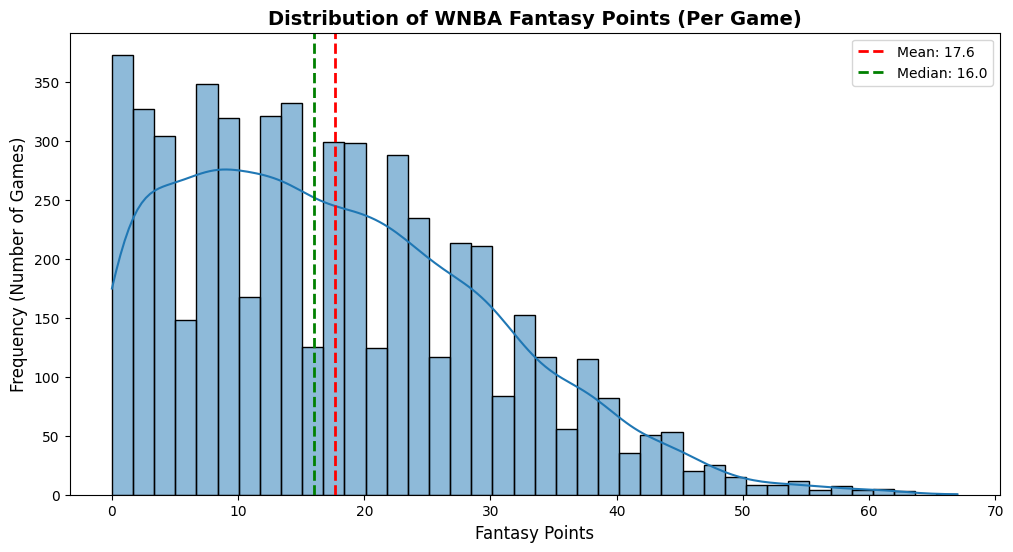

Calculating Naive Baseline (Predicting previous historical average)...
------------------------------
📉 Naive Baseline MAE:  6.77 Fantasy Points
📉 Naive Baseline RMSE: 8.68 Fantasy Points


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import numpy as np

# --- 1. Filter the Noise ---
print(f"Original shape: {df.shape}")

# Count games per player
game_counts = df['PLAYER_ID'].value_counts()

# Keep only players who meet our Gov-Grade threshold
valid_players = game_counts[game_counts >= config.MIN_GAMES_THRESHOLD].index
df_filtered = df[df['PLAYER_ID'].isin(valid_players)].copy()

print(f"Filtered out {len(game_counts) - len(valid_players)} players with < {config.MIN_GAMES_THRESHOLD} games.")
print(f"New shape: {df_filtered.shape}")

# --- 1. Visualizing the Distribution ---
plt.figure(figsize=(12, 6))
sns.histplot(df['FANTASY_PTS'], bins=40, kde=True, color='#1f77b4')

# Add trend lines
mean_pts = df['FANTASY_PTS'].mean()
median_pts = df['FANTASY_PTS'].median()
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_pts:.1f}")
plt.axvline(median_pts, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median_pts:.1f}")

plt.title('Distribution of WNBA Fantasy Points (Per Game)', fontsize=14, fontweight='bold')
plt.xlabel('Fantasy Points', fontsize=12)
plt.ylabel('Frequency (Number of Games)', fontsize=12)
plt.legend()
plt.show()

# --- 2. The "Naive Baseline" Model ---
print("Calculating Naive Baseline (Predicting previous historical average)...")

# Ensure chronological order to prevent data leakage (time travel)
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df = df.sort_values(by=['PLAYER_ID', 'GAME_DATE'])

# Calculate a player's average points *up to the previous game*
# .shift(1) is critical: it hides today's score from the average
df['BASELINE_PRED'] = df.groupby('PLAYER_ID')['FANTASY_PTS'].transform(lambda x: x.expanding().mean().shift(1))

# Drop the first game of the season for each player (since they have no history to average)
baseline_df = df.dropna(subset=['BASELINE_PRED', 'FANTASY_PTS'])

# Evaluate the error
mae = mean_absolute_error(baseline_df['FANTASY_PTS'], baseline_df['BASELINE_PRED'])
rmse = np.sqrt(np.mean((baseline_df['FANTASY_PTS'] - baseline_df['BASELINE_PRED'])**2))

print("-" * 30)
print(f"📉 Naive Baseline MAE:  {mae:.2f} Fantasy Points")
print(f"📉 Naive Baseline RMSE: {rmse:.2f} Fantasy Points")